# Data Modelling

This script will
* placeholder

In [1]:
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# Optional: VIF (will skip gracefully if statsmodels not installed)
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False

# Paths
DATA_PROCESSED = Path("../data/processed/hr_attrition_clean.csv")
MODELS_DIR     = Path("../models")
CONFIG_DIR     = Path("../config")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
CONFIG_DIR.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(DATA_PROCESSED)
print(df.shape)
df.head()

(25000, 40)


,employee_id,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,...,leave_last_yr,team_id,exit_interview_scheduled,offboarding_ticket_created,attrited,months_since_hire,salary_band,commute_zero,internal_moves_flag,stock_grants_flag
0,121752,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,...,0,85,0,0,0,69.1,q4,0,0,0
1,107208,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,...,1,6,0,0,0,110.2,q5,0,0,1
2,117058,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,...,0,177,0,0,0,89.1,q3,0,1,0
3,120754,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,...,0,232,0,0,0,138.8,q4,1,0,1
4,122505,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,...,0,328,1,0,1,85.8,q3,0,0,0


In [2]:
# --- Target
TARGET_COL = "attrited"
assert TARGET_COL in df.columns, f"Missing target column: {TARGET_COL}"

# --- Domain / leakage based drops
candidate_drops = [
    "employee_id",                # identifier
    "exit_interview_scheduled",   # leakage
    "offboarding_ticket_created", # leakage
    "months_since_hire",          # dup of tenure_years
    "salary_band",                # highly correlated with base_salary
    # "role",                     # highly correlated with department
]

drop_cols = [c for c in candidate_drops if c in df.columns]
print("Dropping (domain/leakage):", drop_cols)

df_model = df.drop(columns=drop_cols)

Dropping (domain/leakage): ['employee_id', 'exit_interview_scheduled', 'offboarding_ticket_created', 'months_since_hire', 'salary_band']


In [3]:
# I want to test whether high workload combined with poor manager performance can strongly influence attrition

# Create a binary flag to show if there's a suspected poor manager and high workload for an employee (for stakeholder insights)
def make_mgmt_workload_risk(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    df["mgmt_workload_risk"] = (
        (mq.isna()) |
        ((mq < 5) & (wl > 7))
    ).astype(int)

    return df

df_model = make_mgmt_workload_risk(df_model)
df_model.head()

,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,remote_status,...,benefit_score,sick_days,pto_days_taken,leave_last_yr,team_id,attrited,commute_zero,internal_moves_flag,stock_grants_flag,mgmt_workload_risk
0,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,hybrid,...,6.99,9.1,16.7,0,85,0,0,0,0,0
1,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,hybrid,...,7.75,8.4,15.6,1,6,0,0,0,1,0
2,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,onsite,...,6.76,6.6,19.5,0,177,0,0,1,0,0
3,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,remote,...,7.84,9.4,18.8,0,232,0,1,0,1,0
4,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,onsite,...,6.05,5.4,17.4,0,328,1,0,0,0,0


In [4]:
# Create a continuous column for poor manager/high workload risk to assist with model predictive power

def make_mgmt_workload_score(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    scaler = MinMaxScaler()
    df["mgmt_workload_score"] = scaler.fit_transform(
        (10 - mq + wl).to_numpy().reshape(-1, 1)
    )

    return df

df_model = make_mgmt_workload_score(df_model)
df_model.head()

,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,remote_status,...,sick_days,pto_days_taken,leave_last_yr,team_id,attrited,commute_zero,internal_moves_flag,stock_grants_flag,mgmt_workload_risk,mgmt_workload_score
0,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,hybrid,...,9.1,16.7,0,85,0,0,0,0,0,0.476162
1,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,hybrid,...,8.4,15.6,1,6,0,0,0,1,0,0.466031
2,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,onsite,...,6.6,19.5,0,177,0,0,1,0,0,0.432062
3,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,remote,...,9.4,18.8,0,232,0,1,0,1,0,0.651371
4,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,onsite,...,5.4,17.4,0,328,1,0,0,0,0,0.451728


In [5]:
# Split X / y
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL].astype(int)  # ensuring binary 0/1

In [6]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))

Numeric features: 28
Categorical features: 8


In [7]:
# Checking for multicollinearity

if HAS_STATSMODELS and len(num_cols) > 1:
    # VIF requires no missing values; just in case:
    X_num = X[num_cols].copy()
    X_num = X_num.fillna(X_num.median(numeric_only=True))
    # Add tiny jitter to perfectly constant columns to avoid singularities
    X_num = X_num + 1e-9 * np.random.randn(*X_num.shape)

    vif_df = pd.DataFrame({
        "feature": num_cols,
        "VIF": [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
    }).sort_values("VIF", ascending=False)

    display(vif_df.head(20))

    # Rule of thumb: VIF > 10 is problematic -> candidate for drop
    high_vif = vif_df.loc[vif_df["VIF"] > 10, "feature"].tolist()
    print("High VIF candidates (>10):", high_vif)

    # You can be conservative: drop none automatically, but record them:
    with open(CONFIG_DIR / "high_vif_candidates.json", "w") as f:
        json.dump({"high_vif_candidates": high_vif}, f, indent=2)
else:
    print("Skipping VIF (statsmodels not available or <2 numeric features).")

,feature,VIF
27,mgmt_workload_score,218.282505
11,manager_quality,153.356792
12,workload_score,151.559714
8,internal_moves_last_2y,8.582223
24,internal_moves_flag,8.581766
25,stock_grants_flag,3.929202
17,stock_grants,2.387234
4,base_salary,2.375228
0,is_manager,2.344261
23,commute_zero,1.712880


High VIF candidates (>10): ['mgmt_workload_score', 'manager_quality', 'workload_score']


In [ ]:
# Domain + multicollinearity-driven drops
drop_vif_cols = [
    "compa_ratio",         # very high collinearity with salary
    "avg_raise_3y",        # overlaps with compa_ratio & salary
    "benefit_score",       # collinear with engagement_score
    "manager_quality",     # redundant with the addition of mgmt_workload_score
    "workload_score"       # redundant with the addition of mgmt_workload_score
    "stock_grants"         # retaining stock grants flag
    "age",                 # overlaps with tenure_years
    "internal_moves_last_2y"  # redundant with internal_moves_flag
    "mgmt_workload_risk" # redundant as retaining the continuous score 
]

X = X.drop(columns=[c for c in drop_vif_cols if c in X.columns])
num_cols = [c for c in num_cols if c not in drop_vif_cols]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

len(X_train), len(X_test), y.mean()

(17500, 7500, 0.16592)

In [10]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False))  # with_mean=False is safer for sparse later
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [11]:
selector = SelectFromModel(
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1),
    threshold="median",  # keep features ≥ median importance
    prefit=False
)

In [12]:
# Logistic Regression (interpretable baseline)
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=None))
])

# Random Forest (stronger non-linear baseline)
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])


=== Logistic Regression + SelectFromModel ===
              precision    recall  f1-score   support

           0      0.837     0.985     0.905      6256
           1      0.312     0.035     0.062      1244

    accuracy                          0.827      7500
   macro avg      0.574     0.510     0.484      7500
weighted avg      0.750     0.827     0.765      7500

AUC: 0.649

=== Random Forest + SelectFromModel ===
              precision    recall  f1-score   support

           0      0.834     1.000     0.910      6256
           1      0.000     0.000     0.000      1244

    accuracy                          0.834      7500
   macro avg      0.417     0.500     0.455      7500
weighted avg      0.696     0.834     0.759      7500

AUC: 0.633


/Users/stewartrobertson/opt/miniconda3/envs/hr-predictive-modelling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stewartrobertson/opt/miniconda3/envs/hr-predictive-modelling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stewartrobertson/opt/miniconda3/envs/hr-predictive-modelling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

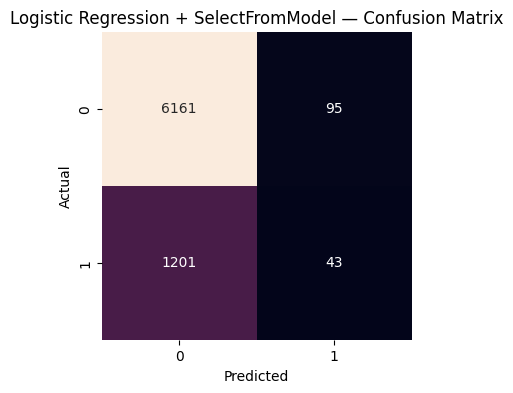

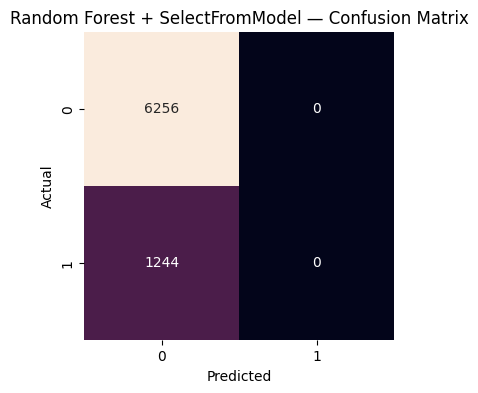

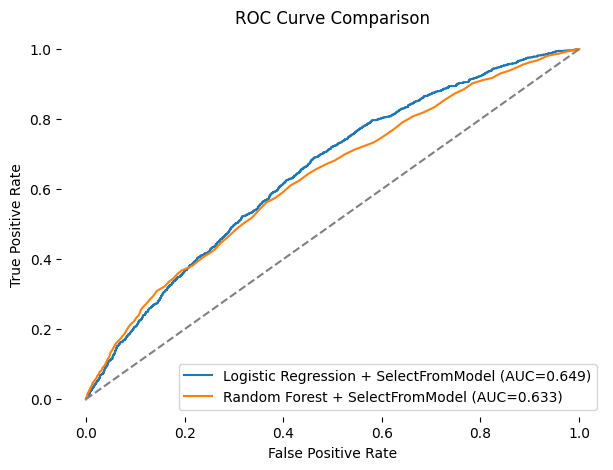

In [13]:
def evaluate(clf, name):
    clf.fit(X_train, y_train)
    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC: {auc:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
    ax.set_title(f"{name} — Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    sns.despine(left=True, bottom=True)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    return {"name": name, "auc": auc, "fpr": fpr, "tpr": tpr, "model": clf}

results = []
results.append(evaluate(pipe_lr, "Logistic Regression + SelectFromModel"))
results.append(evaluate(pipe_rf, "Random Forest + SelectFromModel"))

# ROC curve comparison
fig, ax = plt.subplots(figsize=(7,5))
for r in results:
    ax.plot(r["fpr"], r["tpr"], label=f'{r["name"]} (AUC={r["auc"]:.3f})')
ax.plot([0,1],[0,1],"--",color="gray")
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve Comparison")
ax.legend()
sns.despine(left=True, bottom=True)
plt.savefig('../reports/ROCcomparison.png')
plt.show()

In [14]:
best = max(results, key=lambda r: r["auc"])
best_name = best["name"]
best_model = best["model"]

print("Best model:", best_name)

model_path = MODELS_DIR / "attrition_model.pkl"
joblib.dump(best_model, model_path)
print("Saved:", model_path)

Best model: Logistic Regression + SelectFromModel
Saved: ../models/attrition_model.pkl


In [15]:
# Get transformed feature names
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
num_feats_out = num_cols  # StandardScaler keeps same names
cat_feats_out = ohe.get_feature_names_out(cat_cols).tolist()
all_feats_out = np.array(num_feats_out + cat_feats_out)

# Get selector mask on transformed space
support_mask = best_model.named_steps["select"].get_support()
selected_features = all_feats_out[support_mask]

print(f"Transformed feature count: {len(all_feats_out)}")
print(f"Selected features: {len(selected_features)}")
pd.Series(selected_features).head(30)

Transformed feature count: 5530
Selected features: 2765


0                    is_manager
1                           age
2                    commute_km
3                  tenure_years
4                   base_salary
5                  avg_raise_3y
6     time_since_last_promo_yrs
7        internal_moves_last_2y
8            performance_rating
9              engagement_score
10               workload_score
11       learning_hours_last_yr
12         overtime_hours_month
13                  night_shift
14                schedule_flex
15                 stock_grants
16                    sick_days
17               pto_days_taken
18                leave_last_yr
19                      team_id
20                 commute_zero
21          internal_moves_flag
22            stock_grants_flag
23           mgmt_workload_risk
24          mgmt_workload_score
25     snapshot_date_2020-01-01
26     snapshot_date_2020-01-02
27     snapshot_date_2020-01-04
28     snapshot_date_2020-01-05
29     snapshot_date_2020-01-06
dtype: object

In [16]:
with open(CONFIG_DIR / "selected_features.json", "w") as f:
    json.dump({"selected_transformed_features": selected_features.tolist()}, f, indent=2)
print("Saved selected feature list to config/selected_features.json")

Saved selected feature list to config/selected_features.json


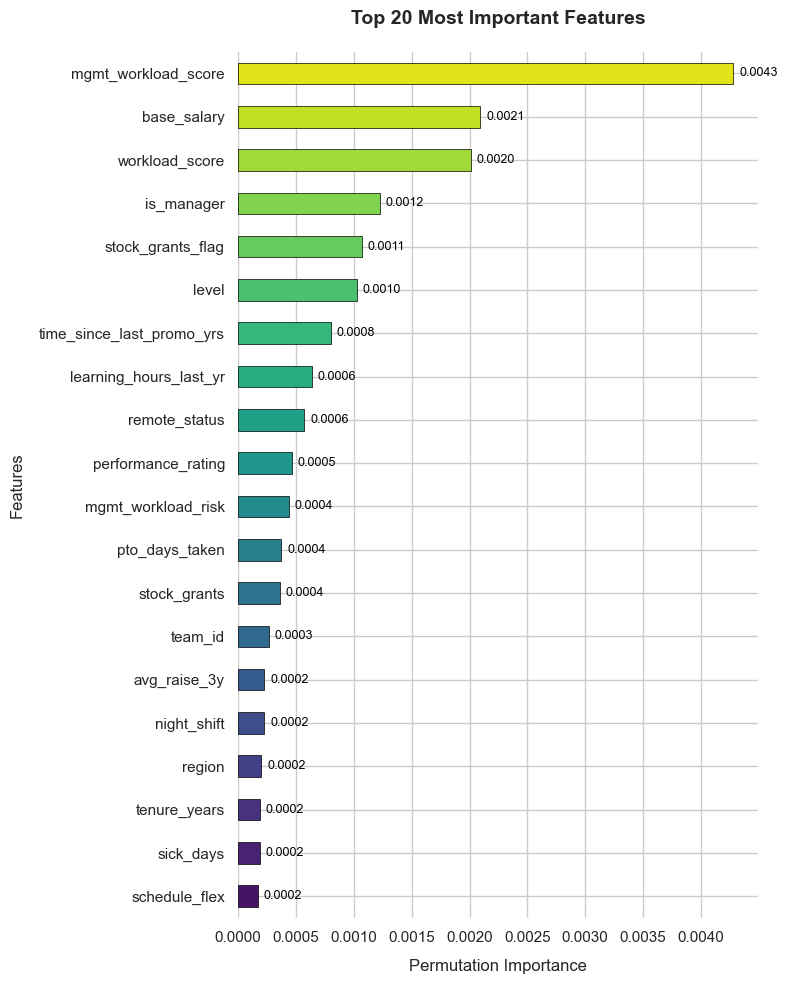

In [17]:
# Run PI on the full pipeline (permutes original cols)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 10))  # Taller figure for portrait orientation

# Run PI on the full pipeline
perm = permutation_importance(best_model, X_test, y_test,
                            n_repeats=10, random_state=42, n_jobs=-1)

# Get feature importances
orig_feature_names = X_test.columns
pi_series = pd.Series(perm.importances_mean, index=orig_feature_names)\
              .sort_values(ascending=True)  # Sort for horizontal bars

# Create horizontal bar plot
ax = pi_series.tail(20).plot(kind='barh', 
                           color=sns.color_palette("viridis", len(pi_series.tail(20))),
                           edgecolor='black', 
                           linewidth=0.5)

# Customize the plot
plt.title('Top 20 Most Important Features', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Permutation Importance', labelpad=10, fontsize=12)
plt.ylabel('Features', labelpad=10, fontsize=12)

# Add value labels
for i, v in enumerate(pi_series.tail(20)):
    ax.text(v + 0.00005, i, f'{v:.4f}', color='black', va='center', fontsize=9)

# Adjust layout and display
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig('../reports/feature_importance.png')
plt.show()